# Breve aplicación de **HyperOpt**

- [Documentación](https://hyperopt.github.io/hyperopt/) de la librería **HyperOpt**.

- [Repositorio](https://github.com/hyperopt/hyperopt) de la librería **HyperOpt**.

Utilizaremos **Keras** para construir nuestros modelos ya que estamos familiarizados con la librería.
De todas maneras, se podría realizar un trabajo similar con *PyTorch* o *Scikit-learn*.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, optimizers, Sequential

**Selección del DataSet**

Elegimos el conjunto de datos de **MNIST** ya que es lo suficientemente simple como para no necesitar dedicarle demasiado tiempo a su estudio, y nos permite concentrarnos propiamente en la aplicación de la librería **HyperOpt**.

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

In [3]:
print(f'Dimensiones de Entrenamiento: {x_train.shape}')
print(f'Longitud de Entrenamiento: {len(y_train)}')

print('----------')

print(f'Dimensiones de Evaluación: {x_test.shape}')
print(f'Longitud de Evaluación: {len(y_test)}')

Dimensiones de Entrenamiento: (60000, 28, 28)
Longitud de Entrenamiento: 60000
----------
Dimensiones de Evaluación: (10000, 28, 28)
Longitud de Evaluación: 10000


Al cargar el dataset, la función retorna cuatro arreglos en `NumPy`:

* Los arreglos `x_train` y `y_train` son los datos del *training set* que se usan para aprender el modelo.
* Los arreglos `x_test` y `y_test` son los datos del *test set* que se usan para probar el modelo.

Las imágenes se cargan como arreglos `NumPy` de 28x28, con valores de píxel que varían de 0 a 255 (imagen en escala de grises). Los arreglos *y* son arreglos de enteros, que van del 0 al 9, con tantas filas como imágenes hay para entrenamiento y para testeo, respectivamente. 

Cada imagen es mapeada a un único dígito. Ya que los nombres de los números no están incluídos en los arreglos *y*, los almacenamos acá para usarlos luego cuando se visualicen las imágenes.

In [4]:
digit_names = ['Cero',
               'Uno',
               'Dos',
               'Tres',
               'Cuatro',
               'Cinco',
               'Seis',
               'Siete',
               'Ocho',
               'Nueve']

**Preprocesamiento del DataSet**

El set de datos debe ser pre-procesado antes de entrenar la red. Al visualizar la primer imagen en el set de entrenamiento, encontramos que los valores de los píxeles están entre 0 y 255:

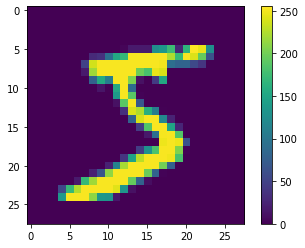

In [5]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

Antes de entrenar la red neuronal debemos escalar estos valores en un rango de 0 a 1. Para hacerlo, dividimos los valores por 255. Es importante que el *training set* y el *testing set* se pre-procesen de la misma forma.

In [6]:
# Normalizamos las imágenes
x_train = x_train / 255.0
x_test = x_test / 255.0

Para verificar que el set de datos está en el formato adecuado, y que están listos para entrenar la red, veamos las primeras 9 imágenes de el *training set* junto al nombre de clase debajo de cada imagen.

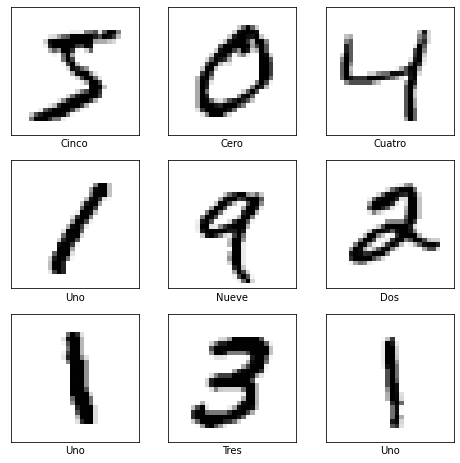

In [7]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(digit_names[y_train[i]])
plt.show()

**Definición de la Red Neuronal**

Definiremos una red neuronal extremadamente simple solo para tener un *baseline* de resultados.
Claramente podríamos intentar mejorar las métricas obtenidas de forma manual, pero el objetivo del trabajo es mostrar la utilidad de **HyperOpt**; por lo tanto, la responsabilidad en la búsqueda de hiperparámetros óptimos es delegada a la librería.

In [8]:
model = Sequential([
    # Al trabajar solo con capas densas, necesitamos vectorizar las imágenes
    layers.Flatten(input_shape=(28, 28)),
    # Una capa densa simple, con alguna función de activación arbitraria
    layers.Dense(32, activation='sigmoid'),
    # Cada una de las salidas corresponde a una de las clases del conjunto
    layers.Dense(10, activation='softmax')
])

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, epochs=1);

1875/1875 [==============================] - 4s 2ms/step - loss: 0.5634 - accuracy: 0.8766


**Cálculo de Métricas**

Es momento de evaluar el desempeño de nuestro modelo *baseline*.

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

313/313 [==============================] - 1s 1ms/step - loss: 0.2848 - accuracy: 0.9244
Test Loss: 0.28482791781425476
Test Accuracy: 0.9243999719619751


El *accuracy* en este conjunto de datos es bastante bueno.
Resulta que clasificar dígitos manuscritos no presenta una tarea tan compleja para una red neuronal.
Intentaremos superar estos resultados aplicando la librería **HyperOpt**.

**Predicciones**

Por último vamos a crear una función que nos permita graficar la probabilidad de clase de cada una de las imágenes del dataset de pruebas.

In [12]:
def plot_image(i, predictions_array, true_label, img, class_names):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel('{} {:2.0f}% ({})'.format(class_names[predicted_label],
                                       100 * np.max(predictions_array),
                                       class_names[true_label]),
             color=color)


def plot_value_array(i, predictions_array, true_label, class_names):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10), class_names, rotation=90)
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color='#777777')
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


def plot_grid(num_rows, num_cols, predictions, test_labels, test_images, class_names):
  """
  Plot the first num_rows * num_cols test images, their predicted labels, and the
  true labels. Color correct predictions in blue and incorrect predictions in red.
  """
  num_images = num_rows * num_cols
  plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], test_labels, test_images, class_names)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions[i], test_labels, class_names)
  plt.tight_layout()
  plt.show()

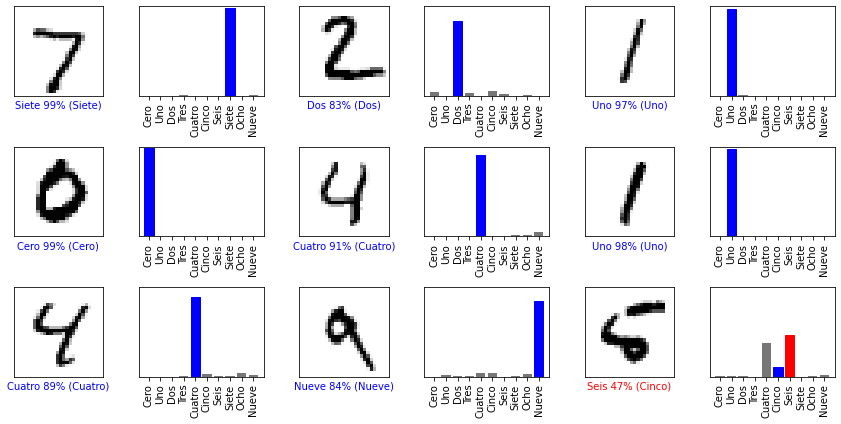

In [13]:
predictions = model.predict(x_test)

plot_grid(3, 3, predictions, y_test, x_test, digit_names)

**Observaciones**

El desempeño de nuestro modelo en esta pequeña muestra es prácticamente perfecto.
Salvo por el ejemplo del `5`, donde se comete un error importante, la red neuronal acertó a la totalidad de sus predicciones realizadas.

# Aplicando HyperOpt

Es momento de intentar superar nuestro *baseline*.

La librería **HyperOpt** nos provee un mecanismo de búsqueda automático de hiperparámetros óptimos.
A grandes rasgos, el procedimiento de aplicación tiene la siguiente forma:
- Se define la **función objetivo**. Nuestra tarea es intentar maximizar (o minimizar) alguna métrica específica sobre algún conjunto de validación.
- Se define el **espacio de búsqueda**. La librería se encargará de probar distintas combinaciones de valores para los hiperparámetros de nuestro modelo, extrayendo los mismos de este conjunto de datos.
- Se define la **cantidad de intentos**. De acuerdo a los recursos con los que se disponga, se determinan la cantidad de experimentos que realizará la librería para aproximar los hiperparámetros óptimos.
- Se realiza la **búsqueda automática de hiperparámetros óptimos**. Una vez se hayan definido todos los elementos necesarios, la librería realizará la búsqueda y retornará la mejor combinación encontrada.

In [14]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=123)

Ahora definimos la **función objetivo**.

La métrica a minimizar entonces, será la *loss* en el conjunto de validación.

In [15]:
from hyperopt import STATUS_OK

# Definición de función objetivo
def objective_function(args):
  # Obtenemos los hiperparámetros del modelo
  hidden_layers = args['hidden_layers']
  activation = args['activation']
  dropout = args['dropout']
  # Obtenemos los hiperparámetros del entrenamiento
  epochs = args['epochs']
  learning_rate = args['learning_rate']
  optimizer = args['optimizer']

  # Modelo
  model = Sequential()
  model.add(layers.Flatten(input_shape=(28, 28)))
  for hidden_units in hidden_layers:
    model.add(layers.Dense(hidden_units, activation=activation))
    model.add(layers.Dropout(dropout))
  model.add(layers.Dense(10, activation='softmax'))

  # Optimizador
  optimizer.learning_rate = learning_rate
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  # Entrenamiento
  model.fit(x_train, y_train, epochs=epochs, verbose=0)

  # Evaluación
  val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)

  return {'loss': val_loss, 'status': STATUS_OK, 'model': model}

Ahora definimos el **espacio de búsqueda**, y la **cantidad de intentos**.

En total, hay 6 hiperparámetros que serán optimizados.
- `hidden_layers` son las capas densas, junto con las neuronas que las componen.
- `activation` es la función no lineal que se aplica luego de cada capa densa.
- `dropout` es la probabilidad de apagar una neurona durante el entrenamiento.
- `epochs` es la cantidad de veces que el modelo aprenderá sobre el entrenamiento.
- `learning_rate` es la velocidad de aprendizaje del modelo.
- `optimizer` es el algoritmo que realiza la optimización sobre el modelo.

In [16]:
from hyperopt import hp, fmin, tpe, Trials, space_eval

hidden_layers_choices = [[32], [64], [128], [32, 32], [64, 64], [32, 64, 32]]
activation_choices = ['relu', 'sigmoid', 'tanh']
optimizer_choices = [optimizers.Adam(), optimizers.RMSprop()]

# Definición del espacio de búsqueda
space = {
    # Sobre el modelo...
    'hidden_layers': hp.choice('hidden_layers', hidden_layers_choices),
    'activation': hp.choice('activation', activation_choices),
    'dropout': hp.uniform('dropout', 0, 0.5),
    # Sobre el entrenamiento...
    'epochs':hp.randint('epochs', 10),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.005)),
    'optimizer': hp.choice('optimizer', optimizer_choices)
    }

# Para almacenar información de los experimentos, se define el objeto Trials
trials = Trials()

# Minimización de la función objetivo sobre el espacio de búsqueda (250 intentos)
best = fmin(objective_function, space, algo=tpe.suggest, max_evals=250, trials=trials)

100%|██████████| 250/250 [1:23:57<00:00, 20.15s/it, best loss: 0.07602649182081223]


Una vez finalizada la búsqueda, veamos cuales fueron los mejores hiperparámetros encontrados...

In [17]:
print('Best hyperparameters...')
print(best)

Best hyperparameters...
{'activation': 0, 'dropout': 0.1998484440611241, 'epochs': 9, 'hidden_layers': 2, 'learning_rate': 0.000768369934269766, 'optimizer': 0}


**Observación**

El diccionario con los mejores hiperparámetros encontrados no trae la selección de `hp.choice`, sino solo su índice en la lista de opciones.

In [18]:
best_model = trials.best_trial['result']['model']

best_model

**Cálculo de Métricas**

Es momento de evaluar el desempeño de nuestro mejor modelo encontrado.

In [19]:
test_loss, test_acc = best_model.evaluate(x_test, y_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

313/313 [==============================] - 1s 2ms/step - loss: 0.0750 - accuracy: 0.9766
Test Loss: 0.07504604756832123
Test Accuracy: 0.9765999913215637


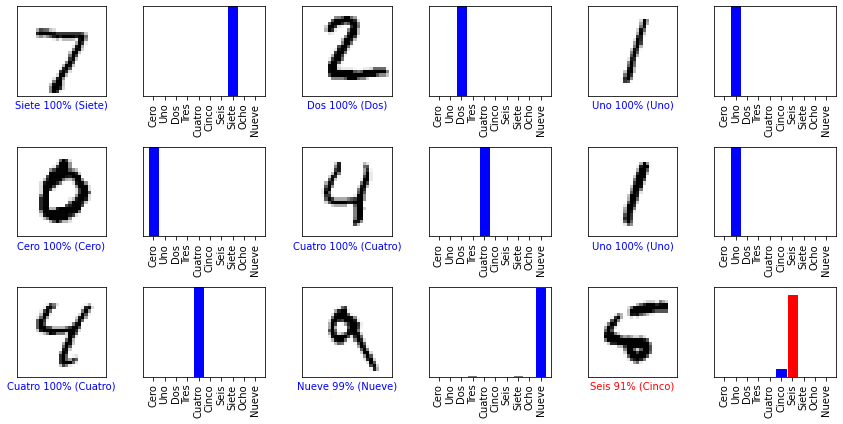

In [20]:
predictions = best_model.predict(x_test)

plot_grid(3, 3, predictions, y_test, x_test, digit_names)

**Conclusión**

Es evidente que estamos trabajando con un conjunto de datos bastante simple.
De todas formas, resulta claro que **HyperOpt** es una herramienta fundamental para buscar hiperparámetros competentes sin exigirle prácticamente ningún esfuerzo adicional al científico de datos.

- Se declara un **espacio de búsqueda** amplio. En caso de contar con algún conocimiento sobre el dominio del problema, se podría refinar manualmente el espacio, lo cual agilizaría la búsqueda aún más.
- Se configura una **cantidad de experimentos** arbitraria. En base a los recursos computacionales (y temporales) con los que cuenta el equipo, se puede ser más o menos persistente en la búsqueda.
- Se define la **función objetivo** a maximizar o minimizar. Quizás esta sea la parte que requiere mayor participación por parte del científico. De todas maneras, su definición no se aparta demasiado de un *pipeline* de *machine learning* cualquiera.

En conclusión, consideramos que la librería es bastante accesible para cualquier científico de datos, provee un mecanismo ágil y simple para automatizar una etapa tediosa en el desarrollo de la ciencia de datos, y demuestra resultados competentes en su aplicación.

En caso de ser necesario, en el siguiente [link](https://github.com/mgobbi289/DiploDatos/blob/main/aprendizajeProfundo/experiment/README.md) se puede encontrar otra aplicación de la librería (realizada por el mismo grupo), a un problema ampliamente más complejo al presentado en esta notebook; el cual puede resultarle más interesante al lector curioso.